## Simple Deep Feed Forward Neural Network

In [726]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
from datetime import date, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [727]:
pd.set_option('display.max_columns', 500)

## Model

In [728]:
class LOBModel(nn.Module):
    def __init__(self, input_dim):
        super(LOBModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 128)
        self.layer5 = nn.Linear(128, 64)
        self.layer6 = nn.Linear(64, 3)

        self.dropout = nn.Dropout(0.03)
        self.relu = nn.ReLU()
        self.norm1 = nn.InstanceNorm1d(512)
        self.norm2 = nn.InstanceNorm1d(256)
        self.norm3 = nn.InstanceNorm1d(512)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        inter1 = self.norm1(self.leaky_relu(self.layer1(x)))
        inter2 = self.dropout(inter1)
        inter3 = self.norm2(self.leaky_relu(self.layer2(inter2)))
        inter4 = self.dropout(inter3)
        inter5 = self.norm3(self.leaky_relu(self.layer3(inter4)))
        inter6 = self.dropout(inter5)
        inter7 = self.leaky_relu(self.layer4(inter6))
        inter8 = self.dropout(inter7)
        inter9 = self.leaky_relu(self.layer5(inter8))
        inter10 = self.layer6(inter9)
        out = self.softmax(inter10)
        return out




### Data

In [729]:
train_data = pd.read_csv("data/Train_NoAuction_Zscore.csv")
train_data = train_data.filter(regex=("\_+"))


test_data = pd.read_csv("data/Test_NoAuction_Zscore.csv")
test_data = test_data.filter(regex=("\_+"))

In [730]:
batch_size = 64

X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
y_train_data = train_data[['label_1']]


X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

y_t = y_train.values
y_train_logits = np.zeros((len(y_t), 3))
for i in range(len(y_t)):
    y_train_logits[i, int(y_t[i, 0]) - 1] = 1

y_v = y_val.values
y_val_logits = np.zeros((len(y_v), 3))
for i in range(len(y_v)):
    y_val_logits[i, int(y_v[i, 0]) - 1] = 1



X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [731]:
y_train_tensor.shape

torch.Size([203800, 3])

### Training and Testing on different labels

In [732]:
def train_model(label="label_1", batch_size=64):    
    X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_train_data = train_data[[label]]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)
    
    y_t = y_train.values
    y_train_logits = np.zeros((len(y_t), 3))
    for i in range(len(y_t)):
        y_train_logits[i, int(y_t[i, 0]) - 1] = 1
    
    y_v = y_val.values
    y_val_logits = np.zeros((len(y_v), 3))
    for i in range(len(y_v)):
        y_val_logits[i, int(y_v[i, 0]) - 1] = 1
    
    
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




    model = LOBModel(X_train.shape[1])


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    
    epochs=20
    
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
    
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
    
    
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
    
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


    
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    plt.title(f'Training and Validation Loss for label={label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.legend()
    
    plt.grid(True)
    plt.show()
    

    X_test_data = test_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_test_data = test_data[[label]]
    
    
    # y_t = y_test_data.values
    # y_test_logits = np.zeros((len(y_t), 3))
    # for i in range(len(y_t)):
    #     y_test_logits[i, int(y_t[i, 0]) - 1] = 1
    
    
    X_test_tensor = torch.tensor(X_test_data.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_data.values, dtype=torch.float32)
    
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            
            probabilities = model(inputs)
            
            _, predicted = torch.max(probabilities, 1)
            predicted = torch.add(predicted, 1)
            
    
            all_preds.extend(predicted.numpy())
            all_labels.extend(targets.numpy())
            
    
            # print(probabilities, predicted, targets.flatten())
            correct_predictions += (predicted == targets.flatten()).sum().item()
            total_predictions += targets.size(0)

    print(f"correct predictions: {correct_predictions:.4f}")
    print(f"total predictions: {total_predictions:.4f}")
    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy:.4f}")



    all_labels = np.array(all_labels)
    all_predictions = np.array(all_preds)
    
    accuracy = accuracy_score(all_labels, all_predictions)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")


    return model

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 0.9881, Validation Loss: 0.9506
Epoch 2/20, Train Loss: 0.9439, Validation Loss: 0.9419
Epoch 3/20, Train Loss: 0.9389, Validation Loss: 0.9400
Epoch 4/20, Train Loss: 0.9375, Validation Loss: 0.9393
Epoch 5/20, Train Loss: 0.9368, Validation Loss: 0.9387
Epoch 6/20, Train Loss: 0.9362, Validation Loss: 0.9382
Epoch 7/20, Train Loss: 0.9358, Validation Loss: 0.9378
Epoch 8/20, Train Loss: 0.9353, Validation Loss: 0.9374
Epoch 9/20, Train Loss: 0.9350, Validation Loss: 0.9370
Epoch 10/20, Train Loss: 0.9347, Validation Loss: 0.9367
Epoch 11/20, Train Loss: 0.9344, Validation Loss: 0.9364
Epoch 12/20, Train Loss: 0.9341, Validation Loss: 0.9362
Epoch 13/20, Train Loss: 0.9339, Validation Loss: 0.9359
Epoch 14/20, Train Loss: 0.9337, Validation Loss: 0.9358
Epoch 15/20, Train Loss: 0.9334, Validation Loss: 0.9355
Epoch 16/20, Train Loss: 0.9330, Validation Loss: 0.9353
Epoch 17/20, Train Loss: 0.9329, Validation Loss: 0.9351
Epoch 18/20, Train Loss: 0.9326, Validat

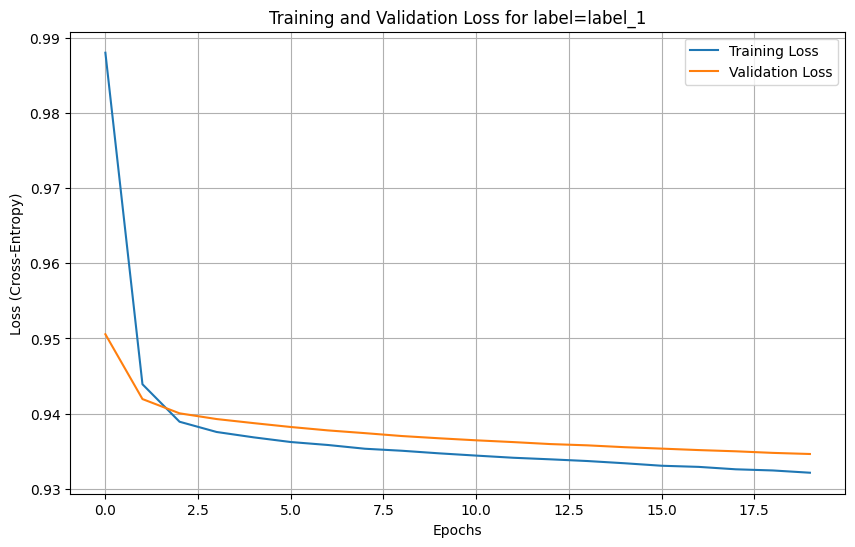

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 98924.0000
total predictions: 139587.0000
Test Accuracy: 0.7087
Accuracy: 0.7087
Weighted Precision: 0.6143
Weighted Recall: 0.7087
Weighted F1-Score: 0.6048


In [733]:
model_1 = train_model(label='label_1')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0607, Validation Loss: 1.0389
Epoch 2/20, Train Loss: 1.0356, Validation Loss: 1.0335
Epoch 3/20, Train Loss: 1.0323, Validation Loss: 1.0318
Epoch 4/20, Train Loss: 1.0306, Validation Loss: 1.0303
Epoch 5/20, Train Loss: 1.0292, Validation Loss: 1.0291
Epoch 6/20, Train Loss: 1.0280, Validation Loss: 1.0280
Epoch 7/20, Train Loss: 1.0269, Validation Loss: 1.0271
Epoch 8/20, Train Loss: 1.0260, Validation Loss: 1.0262
Epoch 9/20, Train Loss: 1.0251, Validation Loss: 1.0255
Epoch 10/20, Train Loss: 1.0243, Validation Loss: 1.0247
Epoch 11/20, Train Loss: 1.0234, Validation Loss: 1.0241
Epoch 12/20, Train Loss: 1.0227, Validation Loss: 1.0234
Epoch 13/20, Train Loss: 1.0222, Validation Loss: 1.0228
Epoch 14/20, Train Loss: 1.0216, Validation Loss: 1.0222
Epoch 15/20, Train Loss: 1.0209, Validation Loss: 1.0218
Epoch 16/20, Train Loss: 1.0203, Validation Loss: 1.0212
Epoch 17/20, Train Loss: 1.0197, Validation Loss: 1.0207
Epoch 18/20, Train Loss: 1.0191, Validat

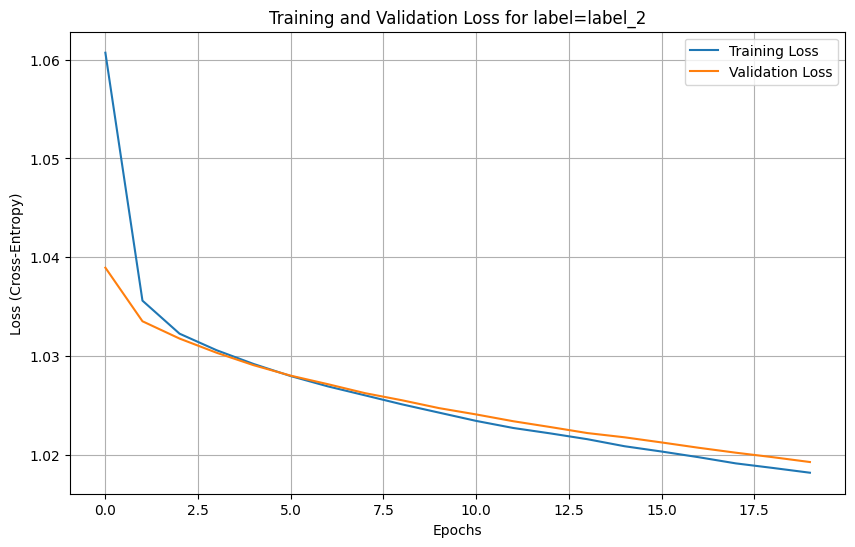

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 86748.0000
total predictions: 139587.0000
Test Accuracy: 0.6215
Accuracy: 0.6215
Weighted Precision: 0.5294
Weighted Recall: 0.6215
Weighted F1-Score: 0.5179


In [734]:
model_2 = train_model(label='label_2')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0834, Validation Loss: 1.0751
Epoch 2/20, Train Loss: 1.0728, Validation Loss: 1.0711
Epoch 3/20, Train Loss: 1.0696, Validation Loss: 1.0687
Epoch 4/20, Train Loss: 1.0672, Validation Loss: 1.0664
Epoch 5/20, Train Loss: 1.0650, Validation Loss: 1.0644
Epoch 6/20, Train Loss: 1.0632, Validation Loss: 1.0627
Epoch 7/20, Train Loss: 1.0613, Validation Loss: 1.0611
Epoch 8/20, Train Loss: 1.0599, Validation Loss: 1.0597
Epoch 9/20, Train Loss: 1.0586, Validation Loss: 1.0584
Epoch 10/20, Train Loss: 1.0574, Validation Loss: 1.0574
Epoch 11/20, Train Loss: 1.0562, Validation Loss: 1.0563
Epoch 12/20, Train Loss: 1.0553, Validation Loss: 1.0553
Epoch 13/20, Train Loss: 1.0544, Validation Loss: 1.0545
Epoch 14/20, Train Loss: 1.0535, Validation Loss: 1.0535
Epoch 15/20, Train Loss: 1.0527, Validation Loss: 1.0528
Epoch 16/20, Train Loss: 1.0521, Validation Loss: 1.0519
Epoch 17/20, Train Loss: 1.0513, Validation Loss: 1.0511
Epoch 18/20, Train Loss: 1.0505, Validat

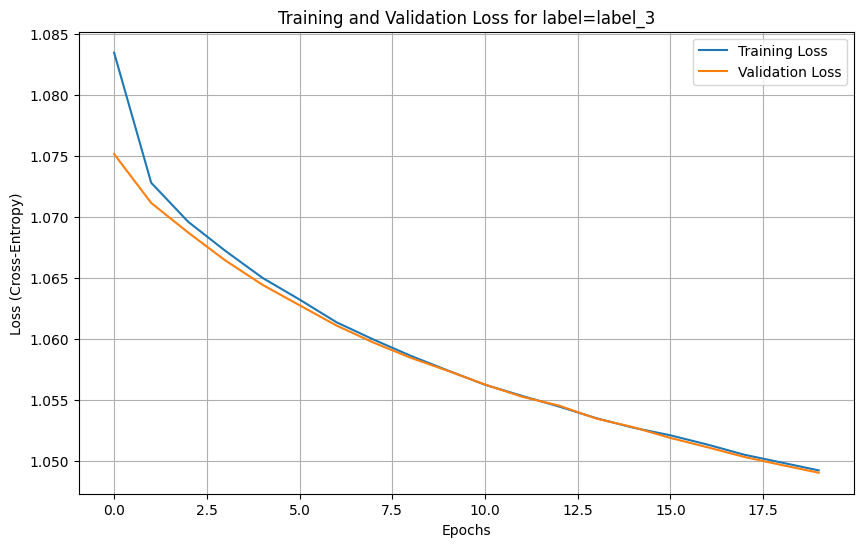

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 76793.0000
total predictions: 139587.0000
Test Accuracy: 0.5501
Accuracy: 0.5501
Weighted Precision: 0.5021
Weighted Recall: 0.5501
Weighted F1-Score: 0.5099


In [735]:
model_3 = train_model(label='label_3')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0940, Validation Loss: 1.0897
Epoch 2/20, Train Loss: 1.0875, Validation Loss: 1.0844
Epoch 3/20, Train Loss: 1.0829, Validation Loss: 1.0804
Epoch 4/20, Train Loss: 1.0793, Validation Loss: 1.0773
Epoch 5/20, Train Loss: 1.0764, Validation Loss: 1.0749
Epoch 6/20, Train Loss: 1.0742, Validation Loss: 1.0729
Epoch 7/20, Train Loss: 1.0723, Validation Loss: 1.0710
Epoch 8/20, Train Loss: 1.0706, Validation Loss: 1.0695
Epoch 9/20, Train Loss: 1.0692, Validation Loss: 1.0681
Epoch 10/20, Train Loss: 1.0679, Validation Loss: 1.0668
Epoch 11/20, Train Loss: 1.0668, Validation Loss: 1.0656
Epoch 12/20, Train Loss: 1.0657, Validation Loss: 1.0644
Epoch 13/20, Train Loss: 1.0646, Validation Loss: 1.0633
Epoch 14/20, Train Loss: 1.0638, Validation Loss: 1.0622
Epoch 15/20, Train Loss: 1.0627, Validation Loss: 1.0611
Epoch 16/20, Train Loss: 1.0618, Validation Loss: 1.0600
Epoch 17/20, Train Loss: 1.0607, Validation Loss: 1.0589
Epoch 18/20, Train Loss: 1.0598, Validat

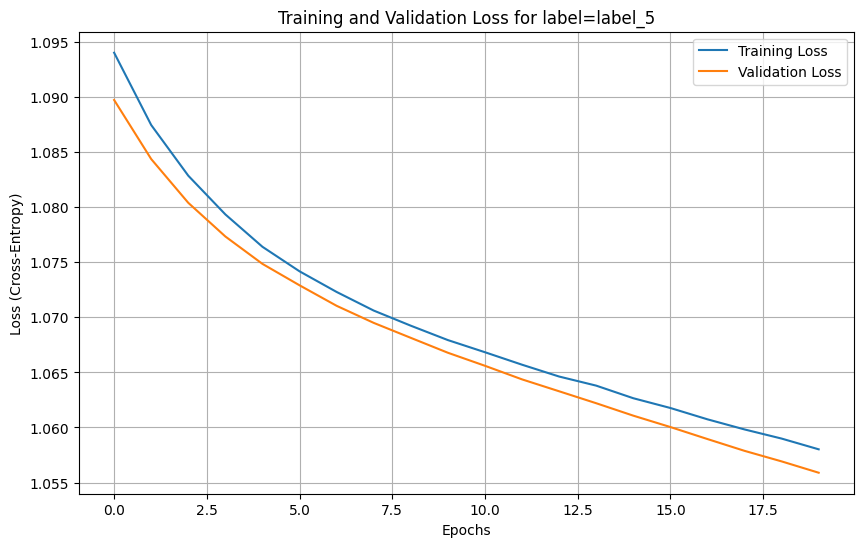

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 63474.0000
total predictions: 139587.0000
Test Accuracy: 0.4547
Accuracy: 0.4547
Weighted Precision: 0.4661
Weighted Recall: 0.4547
Weighted F1-Score: 0.4588


In [736]:
model_5 = train_model(label='label_5')


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1/20, Train Loss: 1.0696, Validation Loss: 1.0562
Epoch 2/20, Train Loss: 1.0519, Validation Loss: 1.0470
Epoch 3/20, Train Loss: 1.0450, Validation Loss: 1.0420
Epoch 4/20, Train Loss: 1.0410, Validation Loss: 1.0391
Epoch 5/20, Train Loss: 1.0385, Validation Loss: 1.0371
Epoch 6/20, Train Loss: 1.0368, Validation Loss: 1.0356
Epoch 7/20, Train Loss: 1.0355, Validation Loss: 1.0342
Epoch 8/20, Train Loss: 1.0343, Validation Loss: 1.0329
Epoch 9/20, Train Loss: 1.0330, Validation Loss: 1.0317
Epoch 10/20, Train Loss: 1.0318, Validation Loss: 1.0304
Epoch 11/20, Train Loss: 1.0308, Validation Loss: 1.0292
Epoch 12/20, Train Loss: 1.0295, Validation Loss: 1.0279
Epoch 13/20, Train Loss: 1.0285, Validation Loss: 1.0267
Epoch 14/20, Train Loss: 1.0274, Validation Loss: 1.0255
Epoch 15/20, Train Loss: 1.0263, Validation Loss: 1.0244
Epoch 16/20, Train Loss: 1.0251, Validation Loss: 1.0235
Epoch 17/20, Train Loss: 1.0244, Validation Loss: 1.0224
Epoch 18/20, Train Loss: 1.0234, Validat

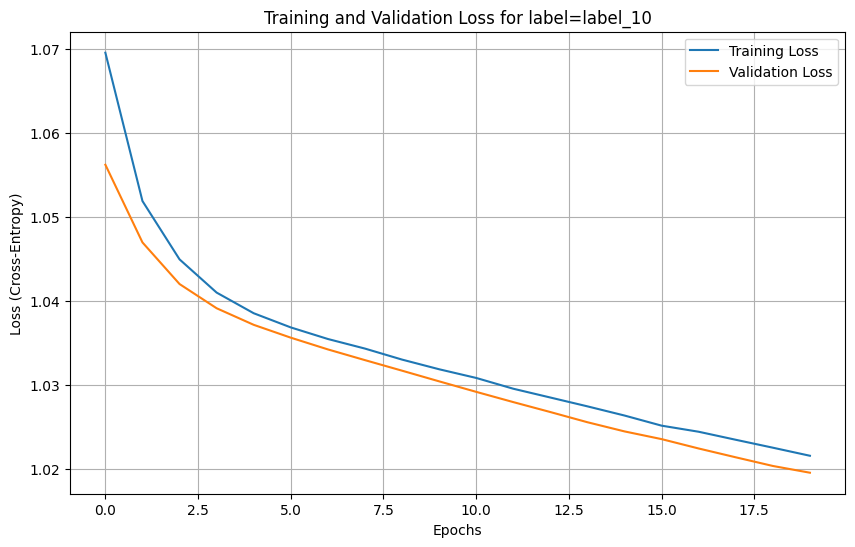

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


correct predictions: 54557.0000
total predictions: 139587.0000
Test Accuracy: 0.3908
Accuracy: 0.3908
Weighted Precision: 0.4304
Weighted Recall: 0.3908
Weighted F1-Score: 0.3365


In [737]:
model_10 = train_model(label='label_10')


In [738]:
torch.save(model_1, 'saved_models/DFN_model_1.pt')
torch.save(model_2, 'saved_models/DFN_model_2.pt')
torch.save(model_3, 'saved_models/DFN_model_3.pt')
torch.save(model_5, 'saved_models/DFN_model_5.pt')
torch.save(model_10, 'saved_models/DFN_model_10.pt')

### Scratch

/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


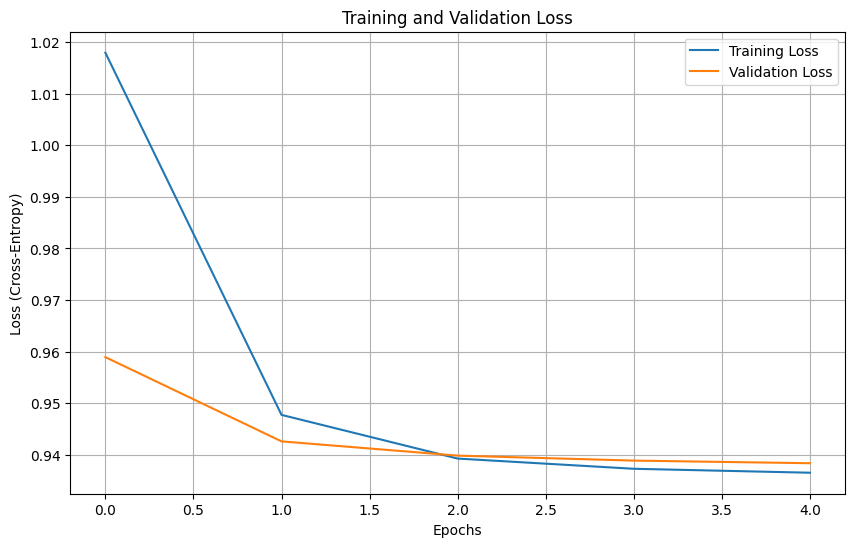

In [686]:
# torch.set_warn_always(False)

# model = LOBModel(X_train.shape[1])


# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# epochs=5


# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     model.train()
#     running_train_loss = 0.0
    

#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
        
#         loss.backward()
#         optimizer.step()
        
#         running_train_loss += loss.item()


#     avg_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    

#     model.eval()
#     running_val_loss = 0.0
    
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             running_val_loss += loss.item()
    
#     avg_val_loss = running_val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
    

#     # print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



# # Plot the training and validation loss curves
# plt.figure(figsize=(10, 6))

# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')

# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss (Cross-Entropy)')
# plt.legend()

# plt.grid(True)
# plt.show()